# Measuring warping while ablating context

In [1]:
import os
import pickle
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

In [2]:
def load_results(results_fn, rep_name, scales):
    """
        Function to load the results
            - result_fn: the path to the result folder
            - rep_name: what type of representation to use (e.g, the averaged representations)
            - scales: different scales to ablate/weaken the context information
    """
    results_dir = '../results/'
    results_fns = [results_fn + '_ablation_ctx_scale' + s + '.P' for s in scales]
    results_paths = [os.path.join(results_dir,fn) for fn in results_fns]
    
    ratio_data, ratio_mean_data = [], []
    for path in results_paths:
        with open(path, 'rb') as f:
            data = pickle.load(f)
    
        # Get ratio results
        analysis = data['analysis']
        ratios = []
        for run in analysis:
            ratios.append([s['distance_ratio'][rep_name]['ratio'] for s in run])
        dist_ratios = np.array(ratios)
        ratio_data.append(dist_ratios)

        mean_ratios = np.mean(dist_ratios, axis=0)
        sem_ratios = np.std(dist_ratios, axis=0) / np.sqrt(len(dist_ratios))
        ratio_mean_data.append((mean_ratios, sem_ratios))

    return np.array(ratio_data), ratio_mean_data

In [3]:
def plot_results(ratio_data, title, save_fn):
    """
        Function to plot the results
            - ratio_data: warping (distance ratio) data 
            - title: title for the plot
            - save_fn: filename to save the result
    """
    n_checkpoints = len(ratio_data[0][0])
    scales = ['%.1f' % s for s in np.linspace(0.1,1,10)]
    x = [i for i in range(n_checkpoints)]
    x_labels = [i*analyze_every for i in range(n_checkpoints)]
    xticks = [2*i for i in range((n_checkpoints // 2) + 1)]
    xtick_labels = [xtick*analyze_every for xtick in xticks]
    cmap = plt.get_cmap('winter')
    colors = [cmap(xx) for xx in reversed(np.linspace(0.2,0.7,len(ratio_data)))]

    fig, ax = plt.subplots()
    for (mu, sem), c in zip(ratio_data, colors):
        ax.errorbar(x, mu, yerr=sem, color=c)
    ax.set_title("Ablating context facilitates warping")
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel("Steps")
    ax.set_ylabel("Distance ratio (incongruent / congruent)")
    ax.set_ylim([0.2, 1.2])
    ax.axhline(y=1, linestyle='--', color='k', linewidth=2)
    
    cbar = plt.colorbar(ScalarMappable(cmap=cmap, norm=plt.Normalize(0, len(scales) - 1)), 
                        ticks=np.arange(len(scales)), label='scales', ax=ax)
                        
    cbar.ax.set_yticklabels(scales)  

    # Save figure
    if save_fn is not None:
        plt.savefig(save_fn, dpi=1000, format='eps', bbox_inches='tight')
    
    plt.show()

In [4]:
def make_tsv(model_name = 'rnn'):
    """
        Funciton to save the results as a tsv file
        - model_name: what model to use 
    """
    in_dir = '../results/' #'Path to results directory with pickle files
    out_dir = '../results/tsv/' #Path to directory to output tsv files
    
    # Make output directory
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)

    # Load basic results
    fn = os.path.join(in_dir, f"{model_name}.P")
    with open(fn, 'rb') as f:
        results = pickle.load(f)

    # Representation
    if model_name == 'mlp':
        rep_name = 'hidden'
    elif model_name == 'rnn':
        rep_name = 'average'

    # Ablation results (warping: t-test and ratio)
    header = []
    data = []
    scales = [f'0.{s}' for s in range(1,10)]
    scales.append('1.0')
    for scale in scales:
        fn = f"{model_name}_ablation_ctx_scale{scale}.P"
        path = os.path.join(in_dir, fn)
        with open(path, 'rb') as f:
            results = pickle.load(f)
        analysis = results['analysis']
        for run_i, run in enumerate(analysis):
            # T-test results
            for stat in ['t_statistic', 'p_value']:
                # Get column of data
                col = np.array([s['ttest'][rep_name][stat] for s in run])
                col = np.expand_dims(col, axis=1)
                data.append(col)

                # Header
                scale_name = f"w{scale}"
                run_name = f"run{run_i}"
                stat_name = stat.replace('_', '-')
                head = f"{scale_name}_{run_name}_{stat_name}"
                header.append(head)

            # Ratio results
            for stat in ['ratio', 'ave_cong_dist', 'ave_incong_dist']:
                # Get column 
                col = np.array([s['distance_ratio'][rep_name][stat] for s in run])
                col = np.expand_dims(col, axis=1)
                data.append(col)

                # Header
                scale_name = f"w{scale}"
                run_name = f"run{run_i}"
                stat_name = stat.replace('_', '-')
                head = f"{scale_name}_{run_name}_{stat_name}"
                header.append(head)
    data = np.concatenate(data, axis=1) # [n_steps, n_runs * n_stats * n_vars]
    header = "\t".join(header) # n_runs * n_stats * n_vars
    out_file = os.path.join(out_dir, f'{model_name}_ablation.tsv')
    print(f"Writing ablation results to {out_file}")
    header_len = len(header.split('\t'))
    print(f"Shape = {data.shape}, header = {header_len}")
    np.savetxt(out_file, data, delimiter='\t', header=header)



#### Scales: 0.1 through 1.0

In [5]:
scales = ['0.%d' % s for s in range(1,10)]
scales.append('1.0')

Loading the results 

In [6]:
results_fn = 'rnn'
rep_name = 'average'
analyze_every = 50
title = "RNN"
save_fn = '../figures/rnn_ablation.eps'

In [7]:
_, ratio_mean_data = load_results(results_fn, rep_name, scales)

Plotting the ablation simulation results which showed as we weakend the context, the level of warping increased 

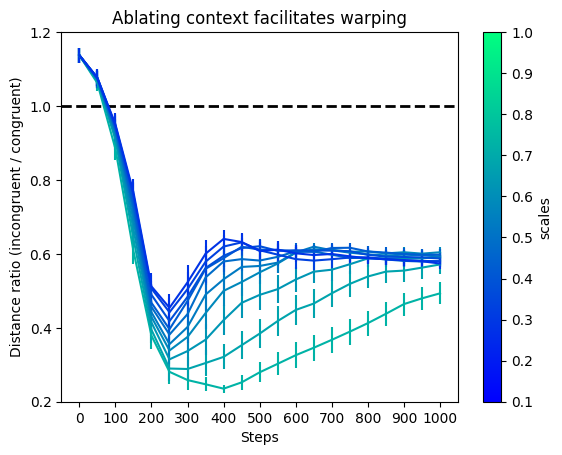

In [8]:
plot_results(ratio_mean_data, title, save_fn)

Save the results to a tsv file 

In [9]:
make_tsv(model_name = 'rnn')

Writing ablation results to ../results/tsv/rnn_ablation.tsv
Shape = (21, 1000), header = 1000


### Statistical test
To test whether the warping is related to the level of ablation

In [10]:
scale_floats = np.expand_dims(np.linspace(0.1,1,10), axis=1)

Loading all the distance ratio data

In [11]:
ratio_all_data, _ = load_results(results_fn, rep_name, scales)

In [ ]:
n_scales, n_runs, n_steps = ratio_all_data.shape

X = []
Y = []
for t in range(n_steps):
    r = ratio_all_data[:,:,t]          # n_scales, n_runs
    w = scale_floats * np.ones_like(r) # n_scales, n_runs
    r = np.matrix.flatten(r) # n_scales * n_runs
    w = np.matrix.flatten(w) # n_scales * n_runs
    
    X.append(sm.add_constant(w))
    Y.append(r)

In [ ]:
regs = []
for x,y in zip(X,Y):
    reg = sm.OLS(y,x).fit()
    regs.append(reg)

The statistical results show that there is a significant main effect of context on the level of warping 

In [ ]:
# whether printing the statistical results for 'all' the steps or only the 'last' step
print_steps = 'last' # or 'all'

if print_steps=='all':
    for step_i, reg in enumerate(regs):
        print(f"Step {step_i*analyze_every}")
        print(reg.summary(xname=['Intercept', 'Omega']))
        print("\n")
elif print_steps=='last':
    print(f"Last Step")
    print(regs[-1].summary(xname=['Intercept', 'Omega']))